In [1]:
!pip install gdown
!gdown --id 1SX2BFJ9lizIyKJDvSV97wEzjQtfR29dv

/opt/conda/lib/python3.7/site-packages/gdown/cli.py:125: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1SX2BFJ9lizIyKJDvSV97wEzjQtfR29dv
To: /kaggle/working/Dataset.zip
100%|██████████████████████████████████████| 2.76G/2.76G [00:35<00:00, 77.2MB/s]


In [ ]:
!unzip '/kaggle/working/Dataset.zip' -d '/kaggle/working/'

In [3]:
import numpy as np
import os
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
print("Num CPU Available: ", len(tf.config.list_physical_devices('CPU')))
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num CPU Available:  1
Num GPUs Available:  1


# Model

In [5]:
# Initialize the base model.
# Set the input shape and remove the dense layers.
vgg19_model = tf.keras.applications.vgg19.VGG19()
vgg19_model.summary()

574710816/574710816 [==============================] - 3s 0us/step
Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                            

In [6]:
last_output = vgg19_model.get_layer('block5_pool').output

pre_trained_model = tf.keras.Model(vgg19_model.input, last_output)

for layer in pre_trained_model.layers:
    layer.trainable = False

pre_trained_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [7]:
def model_creator(dense_num):
  # Flatten the output layer to 1 dimension
  x = tf.keras.layers.Flatten(name = 'flatten')(pre_trained_model.output)
  # Add a fully connected layer with 4 hidden units and ReLU activation
  x = tf.keras.layers.Dense(dense_num, activation='relu', name = 'dense_first')(x)
  # Add a dropout rate of 0.25
  x = tf.keras.layers.Dropout(0.25)(x)                  
  # Add a final sigmoid layer for classification
  x = tf.keras.layers.Dense(1, activation='sigmoid')(x)           

  # Append the dense network to the base model
  model = tf.keras.Model(pre_trained_model.input, x) 

  return model

# Print the model summary. See your dense network connected at the end.
model = model_creator(4)
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

# Dataset

In [9]:
TRAINING_DIR = "/kaggle/working/train"
VALIDATION_DIR = "/kaggle/working/validation"
TEST_DIR = '/kaggle/working/test'

training_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
      rescale = 1./255,
	  rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

validation_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1./255)

train_generator = training_datagen.flow_from_directory(
	TRAINING_DIR,
	target_size=(224,224),
	class_mode='binary',
  batch_size=32
)

validation_generator = validation_datagen.flow_from_directory(
	VALIDATION_DIR,
	target_size=(224,224),
	class_mode='binary',
  batch_size=32
)

test_generator = validation_datagen.flow_from_directory(
	TEST_DIR,
	target_size=(224,224),
	class_mode='binary',
  batch_size=32
)

Found 7726 images belonging to 2 classes.
Found 966 images belonging to 2 classes.
Found 966 images belonging to 2 classes.


# Training

In [10]:
# Re-define the model to train with the optimal learning rate

model = model_creator(4)
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [11]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5) , 
                loss='binary_crossentropy', metrics = ['acc'])

In [12]:
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10,
                                                     restore_best_weights=True)

In [13]:
history = model.fit(train_generator,
                    validation_data = validation_generator,
                    epochs=50,
                    callbacks = [early_stopping_cb],
                    verbose = 1)

Epoch 1/50
242/242 [==============================] - 147s 565ms/step - loss: 0.6900 - acc: 0.5487 - val_loss: 0.6729 - val_acc: 0.8509
Epoch 2/50
242/242 [==============================] - 133s 551ms/step - loss: 0.6665 - acc: 0.5967 - val_loss: 0.6484 - val_acc: 0.8313
Epoch 3/50
242/242 [==============================] - 133s 549ms/step - loss: 0.6476 - acc: 0.6196 - val_loss: 0.6316 - val_acc: 0.8975
Epoch 4/50
242/242 [==============================] - 138s 570ms/step - loss: 0.5989 - acc: 0.6671 - val_loss: 0.5496 - val_acc: 0.7215
Epoch 5/50
242/242 [==============================] - 133s 549ms/step - loss: 0.5498 - acc: 0.7414 - val_loss: 0.5149 - val_acc: 0.8509
Epoch 6/50
242/242 [==============================] - 134s 552ms/step - loss: 0.5239 - acc: 0.7879 - val_loss: 0.4928 - val_acc: 0.8830
Epoch 7/50
242/242 [==============================] - 132s 547ms/step - loss: 0.5101 - acc: 0.8108 - val_loss: 0.4761 - val_acc: 0.8965
Epoch 8/50
242/242 [============================

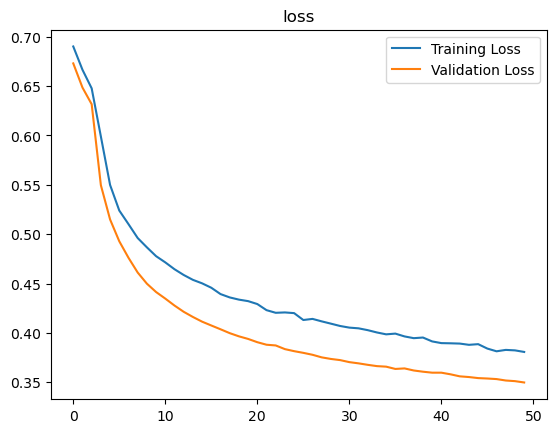

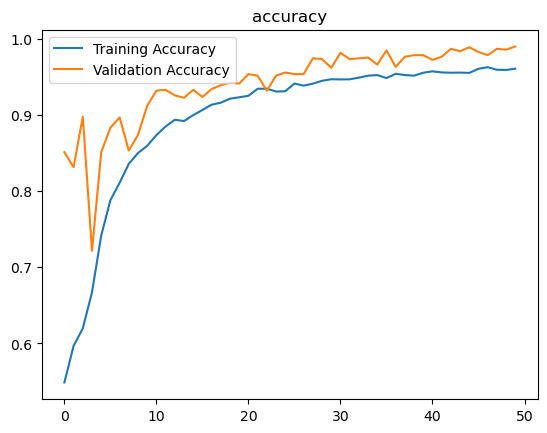

In [14]:
#plot acc and loss

model.save('/kaggle/working/vgg19.h5')

epochs = range(len(history.history['loss']))
plt.plot(epochs , history.history['loss'], label='Training Loss')
plt.plot(epochs , history.history['val_loss'], label='Validation Loss')
plt.title('loss')
plt.legend()

plt.figure()

plt.plot(epochs , history.history['acc'], label='Training Accuracy')
plt.plot(epochs , history.history['val_acc'], label='Validation Accuracy')
plt.title('accuracy')
plt.legend()

plt.show()

# Statistics

In [39]:
test_generator.class_indices

{'covid': 0, 'normal': 1}

In [121]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5) , 
                loss='binary_crossentropy', metrics = ['acc',
                                                      tf.keras.metrics.AUC(),
                                                      tf.keras.metrics.Precision(),
                                                      tf.keras.metrics.Recall(),
                                                      tf.keras.metrics.TruePositives(),
                                                      tf.keras.metrics.TrueNegatives(),
                                                      tf.keras.metrics.FalsePositives(),
                                                      tf.keras.metrics.FalseNegatives()])

In [123]:
a = model.evaluate(test_generator)

31/31 [==============================] - 8s 213ms/step - loss: 0.3498 - acc: 0.9855 - auc_5: 1.0000 - precision_4: 1.0000 - recall_4: 0.9732 - true_positives_2: 508.0000 - true_negatives_1: 444.0000 - false_positives_1: 0.0000e+00 - false_negatives_1: 14.0000


In [130]:
fscore = 2*a[3]*a[4]/(a[3]+a[4])
spc = mx[0, 0] * 1.0 / (mx[0, 0] + mx[0, 1])
sen = mx[1,1] * 1.0 / (mx[1,1] + mx[1,0])
conf_mx = [[a[6], a[7]],[a[8], a[5]]]
mx = np.array(conf_mx)

print('accuracy:',np.round(a[1]*100,2),'%')
print('precision:',np.round(a[3]*100,2),'%')
print('recall:',np.round(a[4]*100,2),'%')
print('Sensitivity:',np.round(sen*100,2),'%')
print('Specificity:',np.round(spc*100,2),'%')
print('f1-score:',np.round(fscore*100,2),'%')
print('AUC:',np.round(a[2]*100,2),'%')

accuracy: 98.55 %
precision: 100.0 %
recall: 97.32 %
Sensitivity: 97.32 %
Specificity: 100.0 %
f1-score: 98.64 %
AUC: 100.0 %
